In [1]:
import pandas as pd 
import networkx as nx
from node2vec import Node2Vec
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
# Implementing link prediction using node2vec for the given dataset
# Dataset contains the following columns for the year 2018: year, exporter_id, importer_id, section_no, value

In [3]:
df = pd.read_csv('edge_data_2018_normalized.csv')
df.head(10)

,year,exporter_id,importer_id,section_no,value
0,2018,ABW,ARE,3,6.997162e-10
1,2018,ABW,ARE,4,3.420166e-07
2,2018,ABW,ARE,6,1.313903e-07
3,2018,ABW,ARE,7,5.140412e-07
4,2018,ABW,ARE,10,1.368551e-08
5,2018,ABW,ARE,11,3.611943e-09
6,2018,ABW,ARE,13,3.049043e-10
7,2018,ABW,ARE,15,2.300894e-07
8,2018,ABW,ARE,16,4.286086e-06
9,2018,ABW,ARE,17,4.207444e-07


In [4]:
df.shape

(287400, 5)

In [5]:
# Check if there are any missing values
df.isnull().sum()

year           0
exporter_id    0
importer_id    0
section_no     0
value          0
dtype: int64

In [6]:
# check if there are any duplicate rows
df.duplicated().sum()

0

In [7]:
# check if there are any duplicate rows only based on exporter_id, importer_id and section_no
df.duplicated(subset=['exporter_id', 'importer_id', 'section_no']).sum()

0

In [8]:
# Creating a directed multigraph
G = nx.MultiDiGraph()

# There will be more than one edge between two nodes if there are multiple trades between them since for each section_no, there is an edge between the exporter and importer
for i in range(len(df)):
    G.add_edge(df['exporter_id'][i], df['importer_id'][i], section_no = df['section_no'][i], value = df['value'][i])

# print the number of nodes and edges in the graph
print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())


Number of nodes:  208
Number of edges:  287400


In [9]:
# List some edges with attributes
for u, v, data in list(G.edges(data=True))[:5]:
    print(f"Edge from {u} to {v} with attributes: {data}")

# Degree analysis
print("Average in-degree:", sum(dict(G.in_degree()).values()) / G.number_of_nodes())
print("Average out-degree:", sum(dict(G.out_degree()).values()) / G.number_of_nodes())


Edge from ABW to ARE with attributes: {'section_no': 3, 'value': 6.99716221636167e-10}
Edge from ABW to ARE with attributes: {'section_no': 4, 'value': 3.4201659830075306e-07}
Edge from ABW to ARE with attributes: {'section_no': 6, 'value': 1.3139028850075333e-07}
Edge from ABW to ARE with attributes: {'section_no': 7, 'value': 5.14041245035629e-07}
Edge from ABW to ARE with attributes: {'section_no': 10, 'value': 1.3685511128202353e-08}
Average in-degree: 1381.7307692307693
Average out-degree: 1381.7307692307693


In [10]:
# Total in-degree and out-degree
total_in_degree = sum(dict(G.in_degree()).values())
total_out_degree = sum(dict(G.out_degree()).values())

print("Total in-degree:", total_in_degree)
print("Total out-degree:", total_out_degree)
print("Number of edges in the graph:", G.number_of_edges())


Total in-degree: 287400
Total out-degree: 287400
Number of edges in the graph: 287400


In [11]:
# Aggregate edges by summing the total value of trade
aggregated_graph = nx.DiGraph()

for u, v, data in G.edges(data=True):
    # Assuming 'trade_value' is a key in your data
    value = data.get('value', 0)  # Default to 0 if key is missing
    if aggregated_graph.has_edge(u, v):
        aggregated_graph[u][v]['weight'] += value  # Add trade value to existing weight
    else:
        aggregated_graph.add_edge(u, v, weight=value)  # Initialize with trade value

print("Number of nodes in aggregated graph:", aggregated_graph.number_of_nodes())
print("Number of edges in aggregated graph:", aggregated_graph.number_of_edges())


Number of nodes in aggregated graph: 208
Number of edges in aggregated graph: 27428


In [12]:
# Sample some edges with their weights
for u, v, data in list(aggregated_graph.edges(data=True))[:10]:
    print(f"Edge from {u} to {v} with total trade value (weight): {data['weight']}")


Edge from ABW to ARE with total trade value (weight): 5.952552350954782e-06
Edge from ABW to ARG with total trade value (weight): 8.678044759956931e-10
Edge from ABW to AUT with total trade value (weight): 3.5794980120236774e-08
Edge from ABW to BEL with total trade value (weight): 1.2000328652518822e-07
Edge from ABW to BFA with total trade value (weight): 3.1663136286329337e-10
Edge from ABW to BHR with total trade value (weight): 7.548491690660916e-07
Edge from ABW to BIH with total trade value (weight): 1.9545145855758855e-11
Edge from ABW to BRA with total trade value (weight): 2.240616430612484e-07
Edge from ABW to BRN with total trade value (weight): 1.5776841734768552e-08
Edge from ABW to CAN with total trade value (weight): 5.229303773708281e-07


In [13]:
# # Visualize the Graph
# plt.figure(figsize=(10, 8))
# pos = nx.spring_layout(aggregated_graph, seed=42)  # Layout for positioning
# edge_weights = [aggregated_graph[u][v]['weight'] for u, v in aggregated_graph.edges()]
# nx.draw(
#     aggregated_graph,
#     pos,
#     node_size=50,
#     edge_color=edge_weights,
#     edge_cmap=plt.cm.viridis,
#     with_labels=False,
# )
# plt.show()


In [14]:
# Remove self-loops
aggregated_graph.remove_edges_from(nx.selfloop_edges(aggregated_graph))


In [15]:

print("Number of nodes in aggregated graph:", aggregated_graph.number_of_nodes())
print("Number of edges in aggregated graph:", aggregated_graph.number_of_edges())

Number of nodes in aggregated graph: 208
Number of edges in aggregated graph: 27400


In [16]:
# Perform node2vec embedding

# 1. Generate Node2Vec embeddings
node2vec = Node2Vec(aggregated_graph, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Access embeddings for a specific node
print(model.wv['ABW'])


Computing transition probabilities:   0%|          | 0/208 [00:00<?, ?it/s]

[-0.0335177   0.03233418  0.4121452   0.33527437  0.13313581 -0.15007204
 -0.28742746  0.12141868 -0.30227658  0.16068073  0.30847803 -0.10608505
 -0.09396819  0.08107993  0.10096279  0.3250869   0.21692745  0.17822635
  0.06179219 -0.04039229  0.17382766 -0.00144621  0.4025862  -0.4350322
  0.25648534 -0.08568493 -0.41612735  0.16639373  0.0122681  -0.04076694
  0.64393526  0.28925607 -0.01838308  0.03026226  0.05356964 -0.7297
 -0.15017883  0.01636375  0.18431988  0.34580895 -0.25703847 -0.07614113
 -0.31316078  0.2537719   0.14055902 -0.20732905 -0.36292553 -0.02217868
  0.16676752 -0.17693566  0.00827406 -0.4704488   0.40480438  0.5461833
  0.26221597  0.22931467  0.02777265 -0.31194615 -0.27283132  0.5490686
  0.33553365 -0.08344784  0.23684752  0.08548813]


In [17]:
# def get_edge_embedding(node1, node2, method="hadamard"):
#     emb1 = model.wv[node1]
#     emb2 = model.wv[node2]
#     if method == "hadamard":
#         return emb1 * emb2  # Hadamard product
#     elif method == "average":
#         return (emb1 + emb2) / 2  # Average
#     elif method == "concat":
#         return np.concatenate([emb1, emb2])  # Concatenation
#     else:
#         raise ValueError("Invalid method. Choose from 'hadamard', 'average', or 'concat'.")


In [18]:
def get_edge_embedding(node1, node2, graph, model, method="concat"):
    emb1 = model.wv[node1]
    emb2 = model.wv[node2]
    # check if there is an edge between the two nodes

    
    if method == "hadamard":
        return (emb1 * emb2)   # Scale Hadamard product by edge weight
    elif method == "average":
        return ((emb1 + emb2) / 2)  # Scale average by edge weight
    elif method == "concat":
        return np.concatenate([emb1, emb2])  # Include edge weight in concatenation
    else:
        raise ValueError("Invalid method. Choose from 'hadamard', 'average', or 'concat'.")


In [19]:
# 2. Create positive and negative samples
positive_edges = list(aggregated_graph.edges())

# def generate_negative_edges(g, num_neg_samples):
#     # Randomly sample pairs of nodes that are not connected
#     num_nodes = g.num_nodes()
#     all_possible_edges = set((i, j) for i in range(num_nodes) for j in range(num_nodes) if i != j)
#     existing_edges = set(zip(g.edges()[0].numpy(), g.edges()[1].numpy()))
#     negative_edges = list(all_possible_edges - existing_edges)
#     negative_edges = negative_edges[:num_neg_samples]
#     return torch.tensor(negative_edges, dtype=torch.int64).T

# all_possible_edges = generate_negative_edges(g, 1000)  # Generate 1000 random potential links

negative_edges = []
# get all pairs of directed edges possible using the nodes in the graph and subtract the positive

for node1 in aggregated_graph.nodes():
    for node2 in aggregated_graph.nodes():
        if node1 != node2 and not aggregated_graph.has_edge(node1, node2):
            negative_edges.append((node1, node2))

negative_edges   # Sample the same number of negative edges as positive edges

[('ABW', 'AFG'),
 ('ABW', 'AGO'),
 ('ABW', 'ALB'),
 ('ABW', 'AND'),
 ('ABW', 'ARM'),
 ('ABW', 'ATG'),
 ('ABW', 'AUS'),
 ('ABW', 'AZE'),
 ('ABW', 'BDI'),
 ('ABW', 'BEN'),
 ('ABW', 'BGD'),
 ('ABW', 'BGR'),
 ('ABW', 'BHS'),
 ('ABW', 'BLR'),
 ('ABW', 'BLZ'),
 ('ABW', 'BMU'),
 ('ABW', 'BOL'),
 ('ABW', 'BRB'),
 ('ABW', 'BTN'),
 ('ABW', 'BWA'),
 ('ABW', 'CAF'),
 ('ABW', 'CMR'),
 ('ABW', 'COD'),
 ('ABW', 'COG'),
 ('ABW', 'COM'),
 ('ABW', 'CPV'),
 ('ABW', 'CUB'),
 ('ABW', 'CUW'),
 ('ABW', 'CYM'),
 ('ABW', 'CYP'),
 ('ABW', 'DJI'),
 ('ABW', 'DMA'),
 ('ABW', 'DZA'),
 ('ABW', 'EGY'),
 ('ABW', 'ERI'),
 ('ABW', 'EST'),
 ('ABW', 'ETH'),
 ('ABW', 'FJI'),
 ('ABW', 'FSM'),
 ('ABW', 'GAB'),
 ('ABW', 'GEO'),
 ('ABW', 'GIB'),
 ('ABW', 'GIN'),
 ('ABW', 'GMB'),
 ('ABW', 'GNB'),
 ('ABW', 'GNQ'),
 ('ABW', 'GRD'),
 ('ABW', 'GRL'),
 ('ABW', 'GUM'),
 ('ABW', 'GUY'),
 ('ABW', 'HRV'),
 ('ABW', 'HTI'),
 ('ABW', 'IRL'),
 ('ABW', 'IRN'),
 ('ABW', 'IRQ'),
 ('ABW', 'ISL'),
 ('ABW', 'JPN'),
 ('ABW', 'KAZ'),
 ('ABW', 'KEN'

In [20]:
len(positive_edges)

27400

In [21]:
len(negative_edges)

15656

In [22]:
# # 3. Combine embeddings and labels
# X = []
# y = []

# # Positive samples
# for u, v in positive_edges:
#     X.append(get_edge_embedding(u, v))
#     y.append(1)

# # Negative samples
# for u, v in negative_edges:
#     X.append(get_edge_embedding(u, v))
#     y.append(0)

# X = np.array(X)
# y = np.array(y)

In [23]:
# Sort positive edges by their weights in ascending order
positive_edges_sorted = sorted(positive_edges, key=lambda edge: aggregated_graph[edge[0]][edge[1]]['weight'])

# Keep only the top 'n' edges based on the number of negative edges
n = len(negative_edges)
downsampled_positive_edges = positive_edges_sorted[-n:]


In [24]:
# 3. Combine embeddings and labels
X = []
y = []

# Positive samples
for u, v in downsampled_positive_edges:
    # Get edge embedding using the modified function that includes edge weight
    X.append(get_edge_embedding(u, v, aggregated_graph, model))
    y.append(1)

# Negative samples
for u, v in negative_edges:
    # Get edge embedding using the modified function that includes edge weight
    X.append(get_edge_embedding(u, v, aggregated_graph, model))
    y.append(0)

X = np.array(X)
y = np.array(y)

# Optional: Check the shape of the resulting feature matrix
print("Feature matrix shape:", X.shape)
print("Label array shape:", y.shape)


Feature matrix shape: (31312, 128)
Label array shape: (31312,)


In [25]:
# 4. Train-test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [26]:
# 5. Train Logistic Regression
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [27]:
# 6. Evaluate the Model 
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]



print("Classification Report:")
print(classification_report(y_test, y_pred))

print("AUC-ROC Score:")
print(roc_auc_score(y_test, y_pred_proba))

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      3132
           1       0.87      0.86      0.86      3131

    accuracy                           0.86      6263
   macro avg       0.86      0.86      0.86      6263
weighted avg       0.86      0.86      0.86      6263

AUC-ROC Score:
0.9335348162179955


In [28]:
# Try different thresholds for classification

# Define thresholds to test
thresholds = np.arange(0.1, 1.0, 0.1)

# Store metrics for each threshold
results = []

for threshold in thresholds:
    # Apply threshold
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    
    # Compute classification report and AUC-ROC
    report = classification_report(y_test, y_pred_threshold, output_dict=True)
    auc = roc_auc_score(y_test, y_pred_proba)


    # Store metrics for comparison
    results.append({
        "Threshold": threshold,
        "Precision_0": report["0"]["precision"],
        "Recall_0": report["0"]["recall"],
        "F1_0": report["0"]["f1-score"],
        "Precision_1": report["1"]["precision"],
        "Recall_1": report["1"]["recall"],
        "F1_1": report["1"]["f1-score"],
        "AUC-ROC": auc,
        "Accuracy": report["accuracy"]
    })

# Print results for each threshold
for result in results:
    print(f"Threshold: {result['Threshold']:.2f}")
    print(f"Precision (Class 0): {result['Precision_0']:.4f}, Recall (Class 0): {result['Recall_0']:.4f}, F1 (Class 0): {result['F1_0']:.4f}")
    print(f"Precision (Class 1): {result['Precision_1']:.4f}, Recall (Class 1): {result['Recall_1']:.4f}, F1 (Class 1): {result['F1_1']:.4f}")
    print(f"AUC-ROC: {result['AUC-ROC']:.4f}")
    print(f"Accuracy: {result['Accuracy']:.4f}\n")



Threshold: 0.10
Precision (Class 0): 0.9670, Recall (Class 0): 0.4588, F1 (Class 0): 0.6223
Precision (Class 1): 0.6452, Recall (Class 1): 0.9844, F1 (Class 1): 0.7795
AUC-ROC: 0.9335
Accuracy: 0.7215

Threshold: 0.20
Precision (Class 0): 0.9407, Recall (Class 0): 0.6427, F1 (Class 0): 0.7637
Precision (Class 1): 0.7286, Recall (Class 1): 0.9594, F1 (Class 1): 0.8282
AUC-ROC: 0.9335
Accuracy: 0.8011

Threshold: 0.30
Precision (Class 0): 0.9163, Recall (Class 0): 0.7344, F1 (Class 0): 0.8153
Precision (Class 1): 0.7783, Recall (Class 1): 0.9329, F1 (Class 1): 0.8486
AUC-ROC: 0.9335
Accuracy: 0.8336

Threshold: 0.40
Precision (Class 0): 0.8895, Recall (Class 0): 0.8151, F1 (Class 0): 0.8507
Precision (Class 1): 0.8294, Recall (Class 1): 0.8988, F1 (Class 1): 0.8627
AUC-ROC: 0.9335
Accuracy: 0.8569

Threshold: 0.50
Precision (Class 0): 0.8590, Recall (Class 0): 0.8672, F1 (Class 0): 0.8630
Precision (Class 1): 0.8658, Recall (Class 1): 0.8576, F1 (Class 1): 0.8617
AUC-ROC: 0.9335
Accuracy

In [29]:
# Use threshold of 0.5 for classification
threshold = 0.5
y_pred_threshold = (y_pred_proba >= threshold).astype(int)
print("Classification Report:")
print(classification_report(y_test, y_pred_threshold))


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      3132
           1       0.87      0.86      0.86      3131

    accuracy                           0.86      6263
   macro avg       0.86      0.86      0.86      6263
weighted avg       0.86      0.86      0.86      6263



In [30]:
# methods = ["hadamard", "average", "concat"]
# results = {}

# for method in methods:
#     X = [get_edge_embedding(u, v, method=method, graph=aggregated_graph, model=model) for u, v in positive_edges + negative_edges]
#     y = [1] * len(positive_edges) + [0] * len(negative_edges)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
#     clf = LogisticRegression(max_iter=1000, random_state=42)
#     clf.fit(X_train, y_train)
#     y_pred_proba = clf.predict_proba(X_test)[:, 1]
    
#     results[method] = roc_auc_score(y_test, y_pred_proba)

# print("AUC-ROC scores by method:")
# print(results)


In [31]:
# Use concatenation method for classification

X = [get_edge_embedding(u, v, method="concat", graph=aggregated_graph, model=model) for u, v in downsampled_positive_edges + negative_edges]
y = [1] * len(downsampled_positive_edges) + [0] * len(negative_edges)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      4697
           1       0.87      0.85      0.86      4697

    accuracy                           0.86      9394
   macro avg       0.86      0.86      0.86      9394
weighted avg       0.86      0.86      0.86      9394



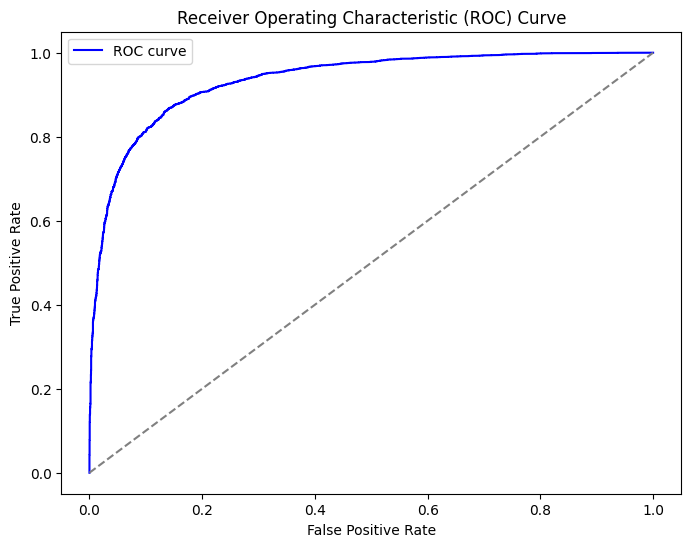

In [32]:
# ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


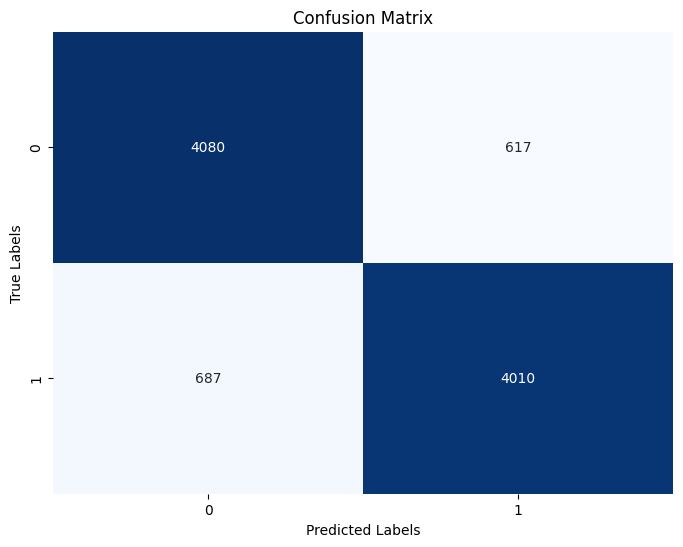

In [33]:
# confusion matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



In [34]:
# Get Predicted Links

In [35]:
# use 2019 data to predict the links
df_2019 = pd.read_csv('edge_data_2019_normalized.csv')
df_2019.head()


,year,exporter_id,importer_id,section_no,value
0,2019,ABW,AGO,16,5.142095e-08
1,2019,ABW,ARE,4,4.985430e-08
2,2019,ABW,ARE,6,4.980711e-08
3,2019,ABW,ARE,7,6.410041e-07
4,2019,ABW,ARE,9,1.626104e-08


In [36]:
df_2019.shape

(299692, 5)

In [37]:
# use 2019 data to predict the links
df_2019 = pd.read_csv('edge_data_2019_normalized.csv')
df_2019.head()

# Create a directed multigraph
G_2019 = nx.MultiDiGraph()

# There will be more than one edge between two nodes if there are multiple trades between them since for each section_no, there is an edge between the exporter and importer
for i in range(len(df_2019)):
    G_2019.add_edge(df_2019['exporter_id'][i], df_2019['importer_id'][i], section_no = df_2019['section_no'][i], value = df_2019['value'][i])

# Aggregate edges by summing the total value of trade
aggregated_graph_2019 = nx.DiGraph()

for u, v, data in G_2019.edges(data=True):
    # Assuming 'trade_value' is a key in your data
    value = data.get('value', 0)  # Default to 0 if key is missing
    if aggregated_graph_2019.has_edge(u, v):
        aggregated_graph_2019[u][v]['weight'] += value  # Add trade value to existing weight
    else:
        aggregated_graph_2019.add_edge(u, v, weight=value)  # Initialize with trade value

print("Number of nodes in aggregated graph 2019:", aggregated_graph_2019.number_of_nodes())
print("Number of edges in aggregated graph 2019:", aggregated_graph_2019.number_of_edges())


Number of nodes in aggregated graph 2019: 208
Number of edges in aggregated graph 2019: 28479


In [38]:
# Remove self-loops
aggregated_graph_2019.remove_edges_from(nx.selfloop_edges(aggregated_graph_2019))


In [39]:

# Generate embeddings for 2019 graph
# node2vec = Node2Vec(aggregated_graph_2019, dimensions=64, walk_length=30, num_walks=200, workers=4)
# model_2019 = node2vec.fit(window=10, min_count=1, batch_words=4)



In [40]:
# Get predicted links

positive_edges_2019 = list(aggregated_graph_2019.edges())

# Negative samples
negative_edges_2019 = []
# get all pairs of directed edges possible using the nodes in the graph and subtract the positive

for node1 in aggregated_graph_2019.nodes():
    for node2 in aggregated_graph_2019.nodes():
        if node1 != node2 and not aggregated_graph_2019.has_edge(node1, node2):
            negative_edges_2019.append((node1, node2))
            


In [41]:
len(positive_edges_2019)

28454

In [42]:
len(negative_edges_2019)

14602

In [43]:
# check if there are any common edges between the positive and negative edges
common_edges = set(positive_edges_2019).intersection(set(negative_edges_2019))
common_edges

set()

In [44]:
# Combine embeddings and labels

X_2019 = [get_edge_embedding(u, v, method="concat", graph=aggregated_graph_2019, model=model) for u, v in positive_edges_2019 + negative_edges_2019]
y_2019 = [1] * len(positive_edges_2019) + [0] * len(negative_edges_2019)


In [45]:
len(X_2019)

43056

In [46]:
# check if there are any duplicate rows in X_2019
X_2019_df = pd.DataFrame(X_2019)
X_2019_df.duplicated().sum()

0

In [47]:
# predict the links
y_pred_2019 = clf.predict(X_2019)
y_pred_proba_2019 = clf.predict_proba(X_2019)[:, 1]

# Get the predicted links
predicted_links = []

for i, (u, v) in enumerate(positive_edges_2019 + negative_edges_2019):
    if y_pred_2019[i] == 1:
        predicted_links.append((u, v))

# Sample some predicted links
predicted_links[:10]


[('ABW', 'AGO'),
 ('ABW', 'ARE'),
 ('ABW', 'ARG'),
 ('ABW', 'AUT'),
 ('ABW', 'CHE'),
 ('ABW', 'CRI'),
 ('ABW', 'DOM'),
 ('ABW', 'ESP'),
 ('ABW', 'GRC'),
 ('ABW', 'HKG')]

In [48]:
len(predicted_links)

21489

In [49]:
print("Classification Report:")
print(classification_report(y_2019, y_pred_2019))


Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.86      0.69     14602
           1       0.90      0.68      0.78     28454

    accuracy                           0.74     43056
   macro avg       0.74      0.77      0.73     43056
weighted avg       0.79      0.74      0.75     43056



In [50]:
# accuracy of the model
accuracy = clf.score(X_2019, y_2019)
print("Accuracy of the model: ", accuracy)


Accuracy of the model:  0.7409188034188035


In [54]:
# AUROC score
auc = roc_auc_score(y_2019, y_pred_proba_2019)
auc

0.8533237642183968

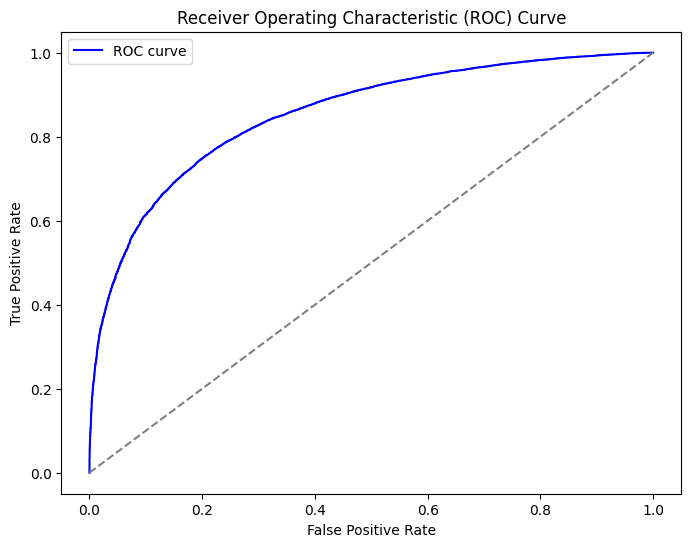

In [52]:
# plot the ROC curve
fpr_2019, tpr_2019, thresholds_2019 = roc_curve(y_2019, y_pred_proba_2019)

plt.figure(figsize=(8, 6))
plt.plot(fpr_2019, tpr_2019, color='blue', label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


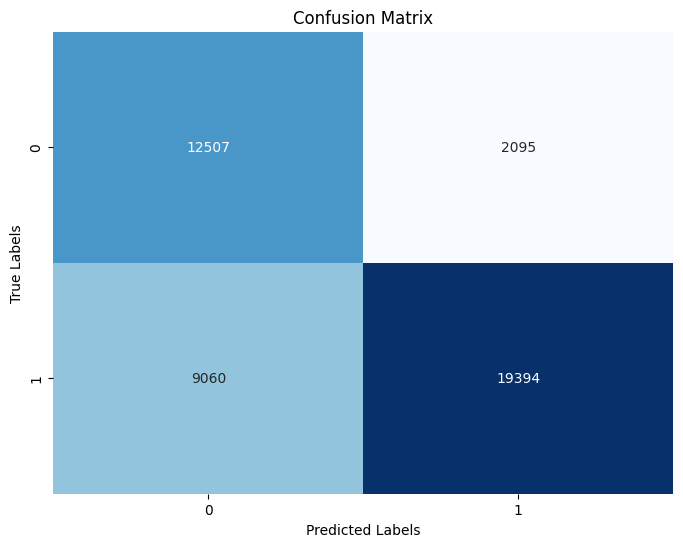

In [53]:
# plot the confusion matrix
conf_matrix_2019 = confusion_matrix(y_2019, y_pred_2019)

plt.figure(figsize=(8, 6))

sns.heatmap(conf_matrix_2019, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

